# Description and Instructions

First, here are the weekly progress slides, where you can attach your own slides you presented this week. This also allows anyone who was not at the meeting to see what we discussed. 
These slides are also in the common [Google Drive folder](https://docs.google.com/presentation/d/1Rd4fOrHJsaspa9cP1Wb7OtlT-J98kX-KtIS0ymMAP0c/edit?usp=sharing). 

I have computing resources available if you need them, especially for large datasets. I suggest you first test your code on small datasets, and when you believe your code is ready, just send it to me, and I can run it locally. Do other researchers here have free space on their computer/available CPUs to run some code? If so, I encourage you to contact them.

As a reminder, the tentative next steps are to find ground truth measurements for what makes a text creepy. I suggest exploring the comments sections and seeing if there are words that are used uncommonly often in creepy text vs non-creepy text (e.g., I suggest using TF-IDF), or if there are words similar to "creepy" that appear often in particularly creepy text.

Finally, some researchers found noon on Monday to be an inconvenient time. Do people prefer another time on Monday? We could move back to 5 p.m., if that works for all of you.

> @Anthony, you wanted to explore how similar a story is to "human", which might even be a good parallel project, as it provides a metric to infer the uncanny valley in text. We could also explore how similar text is to words like "creepy", which dovetails well with our goal of a creepy metric for stories. One method I mentioned is word embedding. Thinking it over, I suggest we meet later this week to discuss how this can be achieved. I will be happy to show you how I created word embeddings, and what we can use to embed text rather than words into a vector space. Once these ideas are finalized, I believe we will be able to quickly make progress.

# Word Embeddings

## Import Library and Poreprocessing the Data

In [53]:
import fasttext

In [54]:
import numpy as np
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_md')

In [115]:
nosleep2020 = pd.read_csv('./Creepy Data/NoSleep/RS_2020_nosleep.csv')

df = nosleep2020[['title', 'selftext', 'score']]
df = df[df.selftext != '[removed]']
df = df[df.selftext != '[deleted]']
df.dropna(subset = ["selftext"], inplace=True)
df = df.replace(r'^\s+','', regex=True) 
df[df.score > 50]

,title,selftext,score
766,I am a detective with the gift of second sight...,Some people have greatness written all over th...,72
782,I am staying with an exchange family in Japan....,[Part 6](https://www.reddit.com/r/nosleep/comm...,726
1045,I am staying with an exchange family in Japan....,[Part 5](https://www.reddit.com/r/nosleep/comm...,74
3125,I'm convinced my son killed his dad,I was fourteen when I had my first child. My d...,75
3248,I took a job as a Fire lookout in the middle o...,[Part 6](https://www.reddit.com/r/nosleep/comm...,61
...,...,...,...
21055,I'm in love with my girlfriend's tattoo.,I was sixteen years old when I first had the d...,280
21070,Mother's Love,"When my mother died, she left me our old child...",53
21072,"On the Pennsylvania Backroads, You Keep Drivin...",The story I’m about to share with you took pla...,406
21080,My sisters and I went to an all girls Catholic...,"I’ve never told anyone this story, not even my...",92


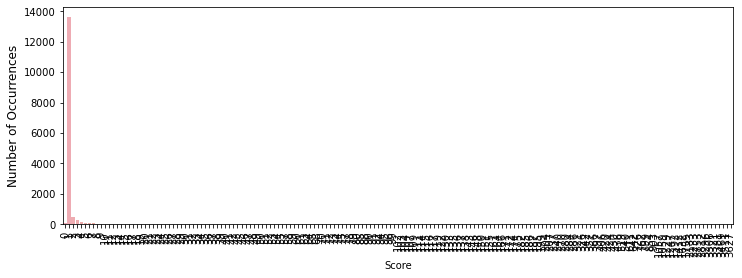

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
scores = df.score.value_counts()

plt.figure(figsize=(12,4))
sns.barplot(scores.index, scores.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Score')
plt.xticks(rotation=90)
plt.show();

# Clean sentences and Lemmatization

In [57]:
def cleansents(text):
    doc = nlp(text)

    sentences = list(doc.sents)

    sentences_cleaned = [] # this will be list of lists. Each list contains tokens of a sentence as strings
    for idx, sents in enumerate(sentences):
        sentences_cleaned.append([])
        for token in sents:
            if not token.is_punct:
                sentences_cleaned[idx].append(token.lemma_)
    return sentences_cleaned

In [257]:
# cleansents(df['selftext'].iloc[0])
docs_cleaned = df['selftext'].head().apply(cleansents)
docs_cleaned

0    [[this, be, the, only, rule, of, -PRON-, house...
1    [[this, be, the, only, rule, of, -PRON-, house...
3    [[-PRON-, be, hard, for, -PRON-, to, talk, abo...
5    [[-PRON-, say, the, devil, be, in, the, detail...
6    [[any, sign, of, -PRON-, yet, \n\n], [-PRON-, ...
Name: selftext, dtype: object

## Some examples of Word2Vec

In [1]:
from gensim.models import Word2Vec
model = Word2Vec(cleansents(df['selftext'].iloc[0]), min_count = 1, size = 100)
model.wv.accuracy

# get the vector of a word
model.wv['household']

model.wv.similarity('this', 'household')

# top 10 similar words in vocab
model.wv.most_similar_cosmul('household', topn = 10)

# given a vector, find the top similarities
model.wv.similar_by_vector(np.zeros(100, dtype = float), topn = 10)

# given a word, find the top similarities
model.wv.similar_by_word("household", topn = 10)

# cosine similarity
model.wv.similarity("while", "household")

model.wv.vocab

# example
model.wv.most_similar(positive=['while', 'household'], negative=['rule'])

model.save('word2vec.model')

NameError: name 'cleansents' is not defined

In [71]:

model.wv.most_similar(positive = "animal")

[('badger', 0.32902300357818604),
 ('go', 0.3218536078929901),
 ('get', 0.29330241680145264),
 ('rule', 0.25406700372695923),
 ('an', 0.24876931309700012),
 ('see', 0.22298695147037506),
 ('shock', 0.22225886583328247),
 ('creature', 0.21616804599761963),
 ('around', 0.21256431937217712),
 ('household', 0.2055148482322693)]

## Some examples of fasttext

In [30]:
np.savetxt('nosleep2020.txt', df[['score','selftext']].values, fmt='%s')

In [269]:
# [[' '.join(sents) for sents in doc] for doc in docs_cleaned.to_list()]

In [346]:
from gensim.models.fasttext import FastText

model = FastText(size=128, window = 12, min_count=1)

model.build_vocab(sentences = cleansents(df.selftext.iloc[0]))
model.train(sentences=cleansents(df.selftext.iloc[0]), total_examples=len(cleansents(df.selftext.iloc[0])), epochs=20)

In [350]:
model.wv.most_similar(positive = ["human", "man", "woman"], negative = "adverb")

[('5', 0.21093954145908356),
 ('eye', 0.182565838098526),
 ('horrify', 0.14730384945869446),
 ('open', 0.12307310849428177),
 ('no', 0.12293888628482819),
 ('cross', 0.10568945109844208),
 ('pretty', 0.10437776893377304),
 ('run', 0.10406724363565445),
 ('set', 0.10227492451667786),
 ('single', 0.10002846270799637)]

In [314]:
model.wv.similarity('human', 'house')

0.0909659

In [299]:
df.selftext.iloc[0]

"This is the only rule of our household. If you feel a presence standing over you while you sleep, do **NOT** open your eyes. Ignore it and try to fall asleep. This may sound a bit like the show Bird Box from Netflix but this is real, this is serious. You don't want to know what happens if you open your eyes. Let me start from the beginning, from where it all began.\n\n------------------------\n\nMy family had just moved to a new house in a new city in an eerily quiet neighborhood. We barely ever saw the neighbors and there were almost no animals around. It threw me off a little bit but i quickly got accustomed to it. My school was pretty close to my house so it was not difficult to make friends that I could regularly bring home. So, a few months in the new house, when i was sleeping one night, i felt a figure standing over me. Now, I have always been a bit of a scaredy cat so I slammed my eyes shut and waited. A few moments later, I felt it go away. This happened to me every night and

In [279]:
max(df.selftext, key = len)

'“Alright, guys, we will take a short break now and begin our hike once everyone is ready. Toilet is down the hall, last door on your right” I said after Lavinia, Toby, and Mimi walked into the family cabin after me. Toby took in his surrounding and nodded in approval while Lavinia rushed to the toilet, she was probably holding in her pee for the past hour. I dropped my hand carry next to the black faux leather couch before sitting down, trying to relax a little after driving for the past 2 hours.\n\nToby and Mimi spent some time exploring the cabin, looking at pictures of previous family gatherings in the cabin while remarking how goofy I looked when I was young. I laughed in response to their teasing. Lavinia returned from the toilet shortly after, volunteered to show them around, clearly still remembering her way around the place from her trip here 2 months ago to meet my family. I took the opportunity to double check the contents of my hiking bag, making sure I have everything we n

In [270]:
model.wv.most_similar("creepy")

[('even', 0.9141172766685486),
 ('difficult', 0.7864644527435303),
 ('school', 0.7781825065612793),
 ('sleep', 0.6567755937576294),
 ('room', 0.6378039717674255),
 ('such', 0.6023737192153931),
 ('about', 0.5972634553909302),
 ('month', 0.5876403450965881),
 ('same', 0.5868575572967529),
 ('much', 0.5778570771217346)]

In [266]:
model.wv['household']

array([ 0.00173925,  0.02513937,  0.00793332,  0.01284806, -0.0147222 ,
       -0.01050904,  0.00935848,  0.02294658], dtype=float32)

In [267]:
model.wv['house']

array([ 0.00063227,  0.03101333,  0.02075868,  0.03140384,  0.00802631,
       -0.01354257,  0.00466461,  0.03090959], dtype=float32)

In [268]:
from gensim.test.utils import common_texts
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

# Retry fasttext

In [353]:
import fasttext

model = fasttext.train_supervised(input="nosleep2020.train")

In [354]:
model['human']

array([ 1.35314744e-02,  8.65187123e-03,  2.40284321e-03, -1.36253340e-02,
        1.68970581e-02,  1.92914363e-02, -1.71355251e-02, -6.89798268e-03,
        1.48539199e-02,  2.21174862e-02, -6.98215468e-03, -2.54741102e-03,
       -1.32349264e-02,  8.75478052e-03, -8.07327498e-03,  4.72321687e-03,
       -3.48434388e-03, -6.50956528e-03,  3.10050818e-04,  3.38251528e-04,
        2.81524193e-03,  2.17929091e-02,  1.08932080e-02, -3.22492281e-03,
       -1.89098436e-02,  3.92926438e-03,  1.28023168e-02, -1.02781132e-02,
       -3.20901908e-03,  6.77986257e-03,  2.49713566e-03, -4.11914708e-03,
       -2.40851864e-02, -1.93119366e-02, -1.85228232e-02, -3.59350699e-03,
       -9.96103510e-03, -4.80608462e-04,  1.96208199e-03, -2.84460164e-03,
        3.06287617e-03,  1.81163810e-02, -8.03209725e-04,  2.23033354e-02,
        2.50377450e-02, -1.24218063e-02,  1.84561089e-02, -1.33921038e-02,
       -9.97486059e-03,  1.87694207e-02, -2.26605535e-02,  9.50213522e-03,
       -1.31522855e-02,  

In [75]:
model.save_model("model_nosleep2020.bin")

In [104]:
text = '''
Whoever is reading this... I urge you to stop now. Please. Before it's too late. I was allowed to put in a warning. One warning. This is all I get. The only chance I have to stop others from suffering a horrible fate. So if you value your life... You'll stop reading.
Seven days... Seven wishes. I didn't believe the stories that my friends told me about the house in the woods. I thought it was all just some silly joke. You see, our town has a legend about an old witch who would grant you seven wishes in seven days... But whatever you wished for had a price. You had to go inside the house and say, "Seven wishes in seven days. I agree to the price I shall pay." and the witch would appear and give you a ribbon. You'd make your first wish, and a black stripe would appear on the ribbon. This would go on for the next seven days, and on the seventh day the witch would demand her price.
One night, my friends and I all went walking through the woods and came across the old house. They pushed me inside and locked the door, telling me to "summon the witch" and then they'd let me out. I hated to admit it, but I was terrified of that dark creepy house and just wanted to get out of there, so I spoke the words. "Seven wishes..." my voice caught in my throat. "I-In seven days... I agree to the price I shall pay."
At first... nothing happened. I was about to turn around and walk out of the house, but then she appeared. The ghost of the witch. She was surprisingly beautiful, and her smile was warm and inviting. Her whole body glowed, and she held her hand out to me, a white ribbon in her palm. I hesitantly raised my hand and took the ribbon, expecting for her to disappear, but she just kept floating there, tilting her head as if she were waiting for something. Waiting... "Oh," I muttered. "Right. My first wish... I wish I was the most beautiful girl in the world."
I'd never been the prettiest flower in the garden. My hair was super frizzy, my eyesight is absolutely terrible, and I was also kind of on the plump side. I dressed like somebody's grandma, more to hide the features I found undesirable than because I wanted to. I just wanted to be beautiful. The witch nodded and disappeared, leaving me alone with my ribbon that now had one black stripe. The door to the house flew open, and I walked out shrugging off my friend's badgering questions with, "It's just a legend."
But my ribbon was shoved in my pocket.
The next day I got up, and was shocked when I looked in the mirror and saw I was now flawless. My skin was clear, my hair was perfect and straight, I didn't need my glasses, and my body was like a model's. My wish had been granted. I put on some of my clothes I only ever wore when I was somewhere with my family since I knew they wouldn't judge me.
My friends were shocked by my sudden transformation, but once again I brushed off their questions and said I'd just lost a lot of weight and had been hiding it for awhile. I walked past Spencer and waved, and his eyes latched on to me. He smiled, and I felt incredibly giddy.
Spencer was my crush, and had been for a really long time. He was the perfect guy. Captain of the football team, smartest guy in school, not to mention super handsome. He also didn't even know I was alive. Sure, I'd tried to get his attention in the past, but it never worked. I'm a really nerdy girl, always have been, but even with the witch's makeover wasn't enough to get him to want to be with me forever like I wanted. It would've taken a miracle to do that.
A miracle... or a wish.
I woke up for school as usual the next day, but when I got there... I was really surprised when Spencer approached me holding a big bouquet of flowers and smiling. "Hi, Anna," he said. "I know this might seem super sudden, but last night I just started thinking about you. I couldn't get you out of my head. Do you think you might want to go out with me?"
I couldn't believe what I was hearing. Spencer... Perfect, handsome, intelligent Spencer, was asking me on a date. I smiled and nodded, "Are you kidding me? Yes!"
That day I felt like I was on cloud nine, and all day Spencer and I were practically inseparable until I had to go to the bathroom. I was washing my hands when Amber and her friends all came out of the other stalls at the same time. I winced. Amber had been bullying me since we were little, and now she was the most popular girl in school, meaning she basically owned the place.
She had also been Spencer's girlfriend.
"So..." she began, tapping a perfectly manicured nail against one of the sinks, "You think you can just steal my boyfriend and get away with it?"
The next thing I knew I'd gotten beaten up and had my face shoved in the toilet. As I stumbled out of the bathroom stall, I saw the witch in the mirror. My hand flew to my pocket, and I pulled out the ribbon with two stripes on it, "I wish I was the queen bee of the school."
Sure enough, my wish was granted. I became popular, and all of my friends joined my royal court. That was three stripes. I still had four more. As the days passed, I made wishes every time I could. I wished to have remarkable intelligence. Four. I wished that my dream school would accept my college education. Five. I wished that when I graduated college I could get my dream job. Six. Finally, I wished that after all that I could live my dream life. Seven.
On the seventh night, after I'd made that wish, the witch appeared in my room. She smiled, "Seven wishes in seven days. Now it is time for my price to be paid."
I nodded, "Okay. What price do you want?"
She chuckled and replied, "For seven wishes that have so drastically changed you and your life, I require seven lives in return."
My eyes widened, "Wha-What? You want the lives of seven people? But how do I even--?"
"Tell them the story of your seven wishes. Of my legend. They shall be the seven whose lives I take," she responded, her smile unfading.
I shook my head, "N-No way! I can't do that! I don't want to see anyone die!"
The witch shrugged, "If you don't wish to pay my price, I will turn back time, and your wishes shall be undone. You will be the only one who remembers. Shall I take away my gifts--?"
"NO!" I exclaimed, reaching out to grab her hand which had risen to turn back time. "There... There must be another way. Something else I can give you."
The witch shook her head, "The price is final, no bargain may be struck. However, you may choose how you tell this story, and you may give one warning not to listen."
And that brings us to now. The only way I can even be slightly absolved of my guilt from having to give the witch seven lives for my seven wishes. You've read the story I begged you not to read. You didn't heed my warnings. And unless more than seven have already seen it...
That means she's coming for you.
'''
model.predict(text.replace(u"\n", " "))


(('__label__1',), array([0.89555889]))

In [351]:
len(df.score.unique())

167

In [355]:
model.test("nosleep2020.valid", k = 5)

(3199, 0.1917474210690841, 0.9587371053454204)

In [356]:
model.get_analogies("human", "man", "woman")

[(0.5640825629234314, 'whistling'),
 (0.5383956432342529, 'cast'),
 (0.5276153087615967, '11.'),
 (0.5245822668075562, 'situation'),
 (0.5215111970901489, 'slept'),
 (0.5163429379463196, 'Vincenzo'),
 (0.5157709121704102,
  '1](https://www.reddit.com/r/nosleep/comments/gc2tf7/when_i_was_15_i_ran_away_and_something_chased_me/)'),
 (0.5128104090690613, 'With'),
 (0.5107607841491699, 'called'),
 (0.5096826553344727, 'head')]

In [132]:
from pprint import pprint as print
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath
from gensim.models import KeyedVectors